# **Capacitor de Placas Paralelas em Série - Elementos Finitos**

Aluno: Juan Felipe Serafim dos Santos

In [1]:
#[K]*[V]= f(1 coluna so) + d(1 coluna so)
#sem densidade volumetrica/superficial/linear de cargas!
#portanto, como f depende da densidade
#
#[K]*[V]= d(1 coluna so)
#
#o intervalo sera de 1 até Ne sendo esses os elementos. Em relacao a z, o
#tamanho total sera dtotal/Ne sendo dtotal o comprimento total

import matplotlib.pyplot as plt
import numpy as np
from math import ceil,floor

##Constantes que definirão o problema
e0=8.85418781*10**(-12)

In [2]:
##Funções utilizadas para a resolução do problema

#dependendo de qual elemento estará durante a resolucao da equacao e definindo a permissividade para tal
def kElement(n,epsilon,e,d1):
  return (epsilon[0]/e)*np.array([[1,-1],[-1,1]]) if (n*e<d1) else (epsilon[1]/e)*np.array([[1,-1],[-1,1]])

#gabarito do resultado ideal
def solucaoAnalitica(z,V_boundary,dtotal,d1:float,d2,epsilon):
  if (z <= dtotal):
    return ((V_boundary[1]*epsilon[1])/(d1*epsilon[1]+d2*epsilon[0]))*z if (z<d1) else ((V_boundary[1]/(d1*epsilon[1]+d2*epsilon[0]))*(epsilon[0]*z+(epsilon[1]-epsilon[0])*d1))
  else:
    return -999.99

def epsilonRef(n,e,d1,epsilon):
  return epsilon[0] if n*e<d1 else epsilon[1]

def voltageResult(z,e,dtotal,V_results): #Ve(x)=Ve1*N1(x)+Ve2*Ne2 calculo do potencial para todo z entre 0 e dtotal considerando cada elemento
  return ( ((ceil(z/e)*e)-z)/e)*V_results[floor(z/e)] + ( (z- (floor(z/e)*e))/e)*V_results[ceil(z/e)] if z<=dtotal else -999.99

def capRef(d1,L,d2,epsilon): ##cálculo analitico da capacitância em série
  return np.array([d1/(epsilon[0]*L*L),d2/(epsilon[1]*L*L)])

In [3]:
##Início da montagem da resolução do potencial nos nós dos elementos
def fem1D(dtotal,d1,L,Ne,er1,er2,V_boundary):

  e=dtotal/Ne #tamanho de cada elemento
  nodes=Ne+1 #numero total de nós com potenciais a serem encontrados
  epsilon=e0*np.array([er1,er2]) #permissividade de cada dieletrico
  #P/ elementos finitos em 1D, as funcoes de produto interno p/ cada elemento serão 4
  K=np.zeros((nodes,nodes))
  d=np.zeros((nodes,1))
  V_results=np.zeros((nodes-2,1))
  K_boundary=np.zeros((nodes-2,nodes-2))
  d_boundary=np.zeros((nodes-2,1))


  #montando a matriz global
  for elem in range(0,Ne):
    for i in range(0,2):
      for j in range(0,2):
        K[i+elem][j+elem]+=kElement(elem,epsilon,e,d1)[i][j]



  #p/ v(0)=vo=0. só pra garantir mesmo, visto que v(0)=0, nao precisaria realizar esse passo
  for elem in range(1,nodes):
    d[elem]-=K[elem][0]*V_boundary[0]


  #substituindo a condicao de contorno v(0)=0,
  #retirando os potenciais conhecidos e alterando a matriz global
  K[0][:]=0
  for i in range(0,nodes):
    K[i][0]=0



  #p/ v(d1+d2)=vo=1
  for elem in range(1,Ne):
    d[elem]-=K[elem][Ne]*V_boundary[1]


  #retirando os potenciais conhecidos e alterando a matriz global
  K[Ne][:]=0
  for i in range(0,nodes):
    K[i][Ne]=0



  #matriz global sem as linhas e colunas de potenciais conhecidos
  for i in range(1, nodes-1):
    for j in range(1, nodes-1):
      K_boundary[i-1][j-1]=K[i][j]


  #o mesmo para o vetor d
  for i in range(1, nodes-1):
    d_boundary[i-1][0]=d[i][0]




  #multiplicando por (1/e0) e eliminando-o do sistema linear
  d_boundary*=(e0**(-1))
  K_boundary*=(e0**(-1))



  #resultado do sistema linear
  V_results=np.linalg.solve(K_boundary,d_boundary)



  #adicionando os valores das condicoes de contorno
  return np.vstack(([V_boundary[0]],V_results,[V_boundary[1]]))


3)
Para o caso em que L = 2 cm, d1 = 1 mm e d2 = 2 mm, εr1 = 2, εr2 = 3 e V0 = 1 V, obteha o sistema linear para um valor de N = N1 + N2 específico (você escolhe). Determine a aproximação para o potencial entre as placas. Plote o resultado.

4)
Repita o item anterior para diferentes valores de N. Plote as soluções para o potencial (V (z) × z), e compare os resultados.

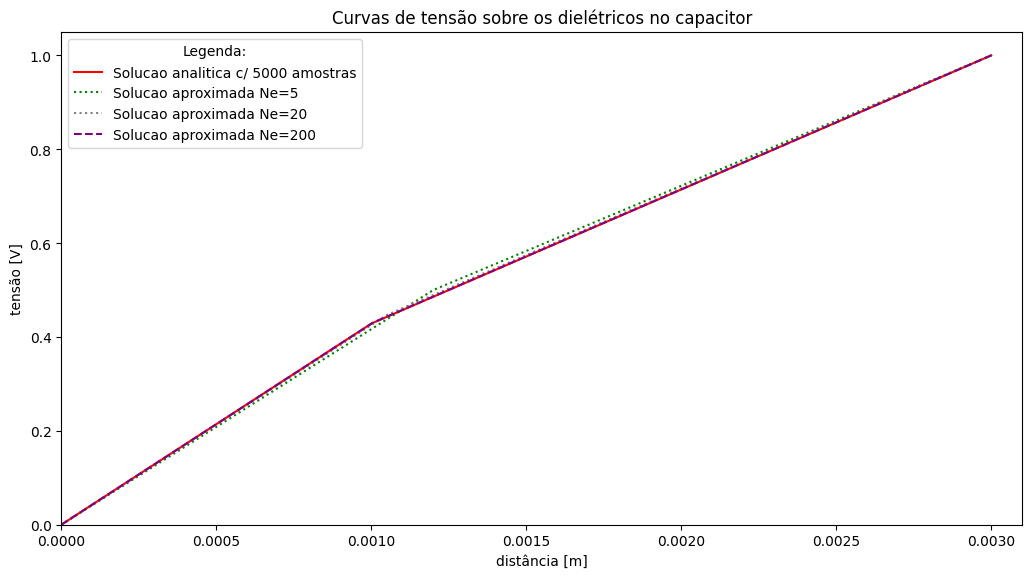

In [4]:
#Definindo valores
#Medidas em metros
L_=0.02
d1_=0.001
dtotal_=0.003
d2_=dtotal_-d1_
Ne_=5
er1_=2
er2_=3
e_=dtotal_/Ne_
V_boundary_=np.array([0,1])
V_results=fem1D(dtotal_,d1_,L_,Ne_,er1_,er2_,V_boundary_)

##valores da solução analitica
intervalo=[]
for i in np.linspace(0,dtotal_,5000):
  intervalo.append(solucaoAnalitica(i,V_boundary_,dtotal_,d1_,d2_,e0*np.array([er1_,er2_])))
intervalo=np.array([intervalo])
intervalo=intervalo.T

#Plotagem das curvas

plt.figure(figsize=(12.4,6.4))
plt.title("Curvas de tensão sobre os dielétricos no capacitor")
plt.xlabel("distância [m]")
plt.ylabel("tensão [V]")
plt.xlim((0,0.0031))
plt.ylim((0,1.05))
plt.plot(np.linspace(0,dtotal_,5000),intervalo,color='red',label='Solucao analitica c/ 5000 amostras')
plt.plot(np.linspace(0,dtotal_,Ne_+1),V_results,color='green',linestyle=':',label='Solucao aproximada Ne=5')


Ne_=20
e_=dtotal_/Ne_
V_results=fem1D(dtotal_,d1_,L_,Ne_,er1_,er2_,V_boundary_)
plt.plot(np.linspace(0,dtotal_,Ne_+1),V_results,color='gray',linestyle=':',label='Solucao aproximada Ne=20')




Ne_=200
e_=dtotal_/Ne_
V_results=fem1D(dtotal_,d1_,L_,Ne_,er1_,er2_,V_boundary_)
plt.plot(np.linspace(0,dtotal_,Ne_+1),V_results,color='purple',linestyle='--',label='Solucao aproximada Ne=200')


plt.legend(title="Legenda:")
plt.show()

5)
Usando a solução acima determine a capactância para diferentes valores de N.

Plote os resultados e observe a convergência. Compare com o valor teórico aproximado da capacitância.

In [5]:
#P/ 20 elementos
dtotal_=0.003
d1_=0.001
d2_=dtotal_-d1_
L_=0.02
Ne_=20
er1_=2
er2_=3
e_=dtotal_/Ne_
capEquiv=0.0

for i in range(0,Ne_+1):
  capEquiv+=(e_/((L_**2)*epsilonRef(i,e_,d1_,epsilon=e0*np.array([er1_,er2_]))))

print("Valor aproximado: "+str(1/capEquiv)+' F'+'\n'+"Num. nós: "+str(Ne_+1))

capReferencia=capRef(d1_,L_,d2_,epsilon=e0*np.array([er1_,er2_]))
print("Valor referencia da sol. analítica: "+str(1/(capReferencia[0]+capReferencia[1]))+" F\n")

#P/ 200 elementos
dtotal_=0.003
d1_=0.001
d2_=dtotal_-d1_
L_=0.02
Ne_=200
er1_=2
er2_=3
e_=dtotal_/Ne_
capEquiv=0.0

for i in range(0,Ne_+1):
  capEquiv+=(e_/((L_**2)*epsilonRef(i,e_,d1_,epsilon=e0*np.array([er1_,er2_]))))

print("Valor aproximado: "+str(1/capEquiv)+' F'+'\n'+"Num. nós: "+str(Ne_+1))
print("Valor referencia da sol. analítica: "+str(1/(capReferencia[0]+capReferencia[1]))+" F\n")

#P/ 3000 elementos
dtotal_=0.003
d1_=0.001
d2_=dtotal_-d1_
L_=0.02
Ne_=3000
er1_=2
er2_=3
e_=dtotal_/Ne_
capEquiv=0.0

for i in range(0,Ne_+1):
  capEquiv+=(e_/((L_**2)*epsilonRef(i,e_,d1_,epsilon=e0*np.array([er1_,er2_]))))

print("Valor aproximado: "+str(1/capEquiv)+' F'+'\n'+"Num. nós: "+str(Ne_+1))
print("Valor referencia da sol. analítica: "+str(1/(capReferencia[0]+capReferencia[1]))+" F")

Valor aproximado: 2.8911633665306123e-12 F
Num. nós: 21
Valor referencia da sol. analítica: 3.0357215348571426e-12 F

Valor aproximado: 3.020618442643927e-12 F
Num. nós: 201
Valor referencia da sol. analítica: 3.0357215348571426e-12 F

Valor aproximado: 3.0348544335903077e-12 F
Num. nós: 3001
Valor referencia da sol. analítica: 3.0357215348571426e-12 F


6)
Agora usando valores de N1 e N2 escolhidos por você varie a espessura do dielétrico 1 (d1) entre 0 e
3 mm, mantendo a espessura total constante d = d1 + d2 = 3 mm.

Plote o resultado.

O que você observa nos limites (em d1 = 0 e d1 = 3 mm)?

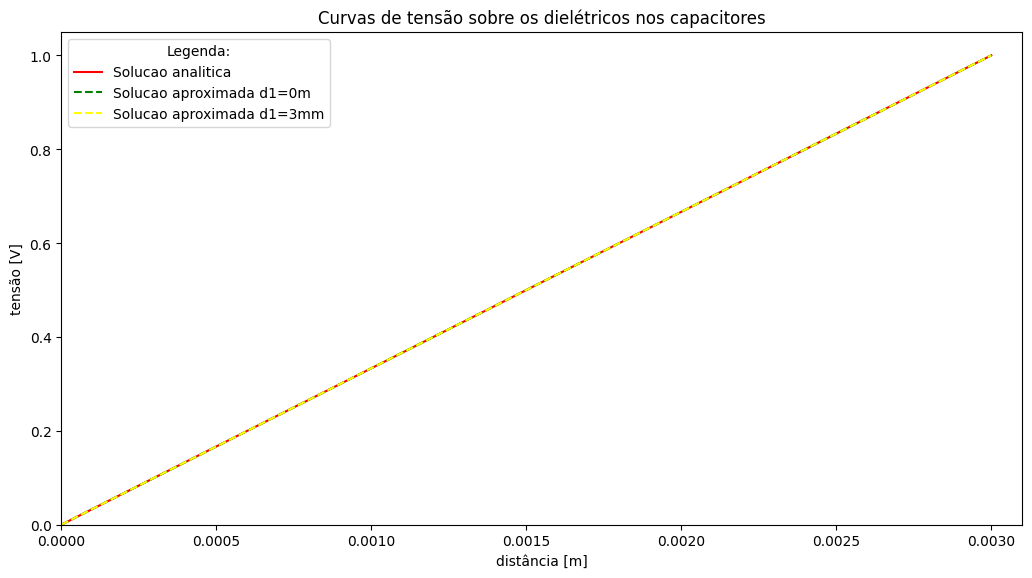

Valor aproximado: 2.357972785619193e-12 F
Num. nós: 501
Distancia d1= 0.003m
Valor referencia da sol. analítica: 2.3611167493333333e-12 F


Valor aproximado: 3.5346059121756746e-12 F
Num. nós: 501
Distancia d1= 0.0m
Valor referencia da sol. analítica: 3.541675124e-12 F


In [8]:
#Variando a espessura do dieletrico p/ d1=0
dtotal_=0.003
d1_=0.0
d2_=dtotal_-d1_
L_=0.02
Ne_=500
er1_=2
er2_=3
e_=dtotal_/Ne_
V_boundary_=np.array([0,1])
V_results=fem1D(dtotal_,d1_,L_,Ne_,er1_,er2_,V_boundary_)


##valores da solução analitica
intervalo=[]
for i in np.linspace(0,dtotal_,Ne_+1):
  intervalo.append(solucaoAnalitica(i,V_boundary_,dtotal_,d1_,d2_,e0*np.array([er1_,er2_])))
intervalo=np.array([intervalo])
intervalo=intervalo.T



plt.figure(figsize=(12.4,6.4))
plt.title("Curvas de tensão sobre os dielétricos nos capacitores")
plt.xlabel("distância [m]")
plt.ylabel("tensão [V]")
plt.xlim((0,0.0031))
plt.ylim((0,1.05))
plt.plot(np.linspace(0,dtotal_,Ne_+1),intervalo,color='red',label='Solucao analitica')
plt.plot(np.linspace(0,dtotal_,Ne_+1),V_results,color='green',linestyle='--',label='Solucao aproximada d1=0m')

####################################
#p/ d1=3mm

d1_=0.003
d2_=dtotal_-d1_
V_results=fem1D(dtotal_,d1_,L_,Ne_,er1_,er2_,V_boundary_)
plt.plot(np.linspace(0,dtotal_,Ne_+1),V_results,color='yellow',linestyle='--',label='Solucao aproximada d1=3mm')
plt.legend(title="Legenda:")
plt.show()


capEquiv=0.0
for i in range(0,Ne_+1):
  capEquiv+=(e_/((L_**2)*epsilonRef(i,e_,d1_,epsilon=e0*np.array([er1_,er2_]))))
print("Valor aproximado: "+str(1/capEquiv)+' F'+'\n'+"Num. nós: "+str(Ne_+1)+"\nDistancia d1= "+str(d1_)+'m')

capReferencia=capRef(d1_,L_,d2_,epsilon=e0*np.array([er1_,er2_]))
print("Valor referencia da sol. analítica: "+str(1/(capReferencia[0]+capReferencia[1]))+" F")


####################################

d1_=0.0
d2_=dtotal_-d1_


capEquiv=0.0
for i in range(0,Ne_+1):
  capEquiv+=(e_/((L_**2)*epsilonRef(i,e_,d1_,epsilon=e0*np.array([er1_,er2_]))))
print("\n\n"+"Valor aproximado: "+str(1/capEquiv)+' F'+'\n'+"Num. nós: "+str(Ne_+1)+"\nDistancia d1= "+str(d1_)+'m')

capReferencia=capRef(d1_,L_,d2_,epsilon=e0*np.array([er1_,er2_]))
print("Valor referencia da sol. analítica: "+str(1/(capReferencia[0]+capReferencia[1]))+" F")


In [10]:
L_=0.02
d1_=0.001
dtotal_=0.003
d2_=dtotal_-d1_
Ne_=500
er1_=2
er2_=3
e_=dtotal_/Ne_
V_boundary_=np.array([0,1])
V_results=fem1D(dtotal_,d1_,L_,Ne_,er1_,er2_,V_boundary_)
for i in np.linspace(0,dtotal_,50):
  print("Valor de z= "+str(i)+' m'+'\n'+str(solucaoAnalitica(i,V_boundary_,dtotal_,d1_,d2_,e0*np.array([er1_,er2_]))))
  print(str(voltageResult(i,e_,dtotal_,V_results)[0])+'\n')

Valor de z= 0.0 m
0.0
0.0

Valor de z= 6.122448979591836e-05 m
0.026239067055393583
0.026231572320446206

Valor de z= 0.00012244897959183673 m
0.05247813411078717
0.052463144640892384

Valor de z= 0.0001836734693877551 m
0.07871720116618075
0.07869471696133855

Valor de z= 0.00024489795918367346 m
0.10495626822157433
0.10492628928178492

Valor de z= 0.0003061224489795918 m
0.13119533527696792
0.13115786160222995

Valor de z= 0.0003673469387755102 m
0.1574344023323615
0.1573894339226756

Valor de z= 0.00042857142857142855 m
0.18367346938775508
0.18362100624312078

Valor de z= 0.0004897959183673469 m
0.20991253644314867
0.2098525785635676

Valor de z= 0.0005510204081632653 m
0.23615160349854225
0.23608415088400875

Valor de z= 0.0006122448979591836 m
0.26239067055393583
0.26231572320445856

Valor de z= 0.000673469387755102 m
0.2886297376093294
0.2885472955248987

Valor de z= 0.0007346938775510204 m
0.314868804664723
0.31477886784534925

Valor de z= 0.0007959183673469387 m
0.3411078717201